<h1>Classification of SVHN using Transfer Learning from pre-trained MNIST CNN</h1>

---



# Importing Keras Modules


In [1]:
#Importing important modules
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading the Dataset

<h3>Load SVHN dataset from a h5 file</h3>

In [3]:
import h5py
import numpy as np

# Open the file as readonly. The file should be present inside a directory called "data" in the same folder as code
h5f = h5py.File('/content/gdrive/My Drive/Colab Notebooks/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()


<h4>Visualizing the dataset</h4>

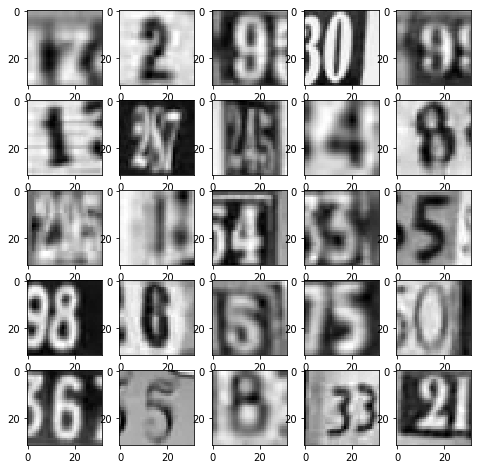

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = x_test[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [5]:
print(x_train.shape)


(42000, 32, 32)


In [6]:
print(x_train.dtype)

float32


<h3>Resize all the train and test inputs to 28X28, to match with MNIST CNN model's input size</h3>



In [7]:
#Importing opencv module for the resizing function
import cv2

#Create a resized dataset for training and testing inputs with corresponding size. Here we are resizing it to 28X28 (same input size as MNIST)
x_train_res = np.zeros((x_train.shape[0],28,28), dtype=np.float32)
for i in range(x_train.shape[0]):
  #using cv2.resize to resize each train example to 28X28 size using Cubic interpolation
  x_train_res[i,:,:] = cv2.resize(x_train[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

x_test_res = np.zeros((x_test.shape[0],28,28), dtype=np.float32)
for i in range(x_test.shape[0]):
  #using cv2.resize to resize each test example to 28X28 size using Cubic interpolation
  x_test_res[i,:,:] = cv2.resize(x_test[i], dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
  
#We don't need the original dataset anynmore so we can clear up memory consumed by original dataset
del x_train
del x_test

print(x_train_res.shape)
print(x_test_res.shape)


(42000, 28, 28)
(18000, 28, 28)


<h3>Reshape train and test sets into shapes compatible with keras models</h3>

<h4>Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.</h4>


In [8]:
# input image dimensions
img_rows, img_cols = 28, 28


#Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.
x_train = x_train_res.reshape(x_train_res.shape[0], img_rows, img_cols, 1)
x_test = x_test_res.reshape(x_test_res.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

<h3>Pre-processing the dataset</h3>
<h4>Normalizing the input</h4>

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalizing the input
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (42000, 28, 28, 1))
(42000, 'train samples')
(18000, 'test samples')


In [10]:
batch_size = 128
num_classes = 10
epochs = 12

In [11]:
print(y_train[0])

2


<h4>Convert Labels from digits to one hot vectors</h4>

In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [13]:
print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Building the CNN 

<h4>Define the layers of model with same size as the CNN used for MNIST Classification</h4>
<h4>Give appropriate names to each layer to access them later</h4>

In [14]:
#Initialize the model
model = Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,name='conv_1'))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(64, (3, 3), activation='relu',name='conv_2'))

#Add a MaxPooling Layer of size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2),name='max_1'))

#Apply Dropout with 0.25 probability 
model.add(Dropout(0.25,name='drop_1'))

#Flatten the layer
model.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model.add(Dense(128, activation='relu',name='dense_1'))

#Apply Dropout with 0.5 probability 
model.add(Dropout(0.5,name='drop_2'))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model.add(Dense(num_classes, activation='softmax',name='dense_2'))

<h4>Freeze the initial convolutional layer weights and train only the dense(FC) layers</h4>

In [15]:
#Freezing layers in the model which don't have 'dense' in their name
for layer in model.layers:
  if('dense' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False

#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

conv_1
False
conv_2
False
max_1
False
drop_1
False
flatten_1
False
dense_1
True
drop_2
False
dense_2
True


<h4>Load pre-trained weights from MNIST CNN model </h4>

In [16]:
#The pre-trained weights must exist in a folder called "data" in the current folder
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/cnn_mnist_weights.h5')

<h4>Setting Optimizer and Loss function for training</h4>

In [17]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

#To use adam optimizer for learning weights with learning rate = 0.001
optimizer = Adam(lr=0.001)
#Set the loss function and optimizer for the model training
model.compile(loss=categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

# Training the CNN 

<h4>Fit the model to the SVHN dataset</h4>

In [18]:
#Training on the dataset
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 42000 samples, validate on 18000 samples
Epoch 1/12
42000/42000 [==============================] - 10s 241us/step - loss: 1.3426 - accuracy: 0.5832 - val_loss: 0.9105 - val_accuracy: 0.7488
Epoch 2/12
42000/42000 [==============================] - 4s 92us/step - loss: 0.9242 - accuracy: 0.7224 - val_loss: 0.7515 - val_accuracy: 0.7879
Epoch 3/12
42000/42000 [==============================] - 4s 92us/step - loss: 0.7862 - accuracy: 0.7604 - val_loss: 0.6841 - val_accuracy: 0.8074
Epoch 4/12
42000/42000 [==============================] - 4s 93us/step - loss: 0.7134 - accuracy: 0.7809 - val_loss: 0.6382 - val_accuracy: 0.8180
Epoch 5/12
42000/42000 [==============================] - 4s 92us/step - loss: 0.6535 - accuracy: 0.7981 - val_loss: 0.6083 - val_accuracy: 0.8260
Epoch 6/12
42000/42000 [==============================] - 4s 92us/step - loss: 0.6141 - accuracy: 0.8064 - val_loss: 0.5888 - val_accuracy: 0.8351
Epoch 7/12
42000/42000 [==============================] - 4s 91us/

# Evaluating the CNN

<h4>Evaluate trained model on the test set</h4>

In [19]:
#Testing the model on test set
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

18000/18000 [==============================] - 2s 114us/step
('Test loss:', 0.5395367811255984)
('Test accuracy:', 0.8474444150924683)


<h4>Visualizing some predictions</h4>

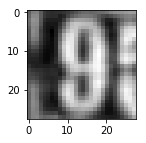

9


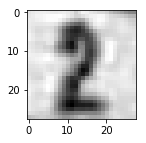

2


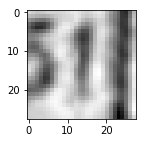

1


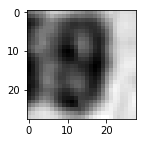

8


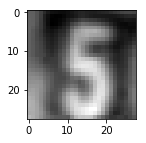

5


In [20]:
import numpy as np

plt.figure(figsize=(2,2))
plt.imshow(x_test[3].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[3].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[2].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[2].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[33].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[33].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[59].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[59].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[36].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[36].reshape(1,28,28,1))))

# Saving the CNN

<h4>Save the trained weights and model in h5 files</h4>

In [21]:
#Set the path where you want to store the model and weights. 
model.save('/content/gdrive/My Drive/Colab Notebooks/cnn_svhn.h5')
model.save_weights('/content/gdrive/My Drive/Colab Notebooks/cnn_svhn_weights.h5')